Saving 374a2d92-9597-40f5-8db3-7d9e51a01e37.jpg to 374a2d92-9597-40f5-8db3-7d9e51a01e37 (10).jpg


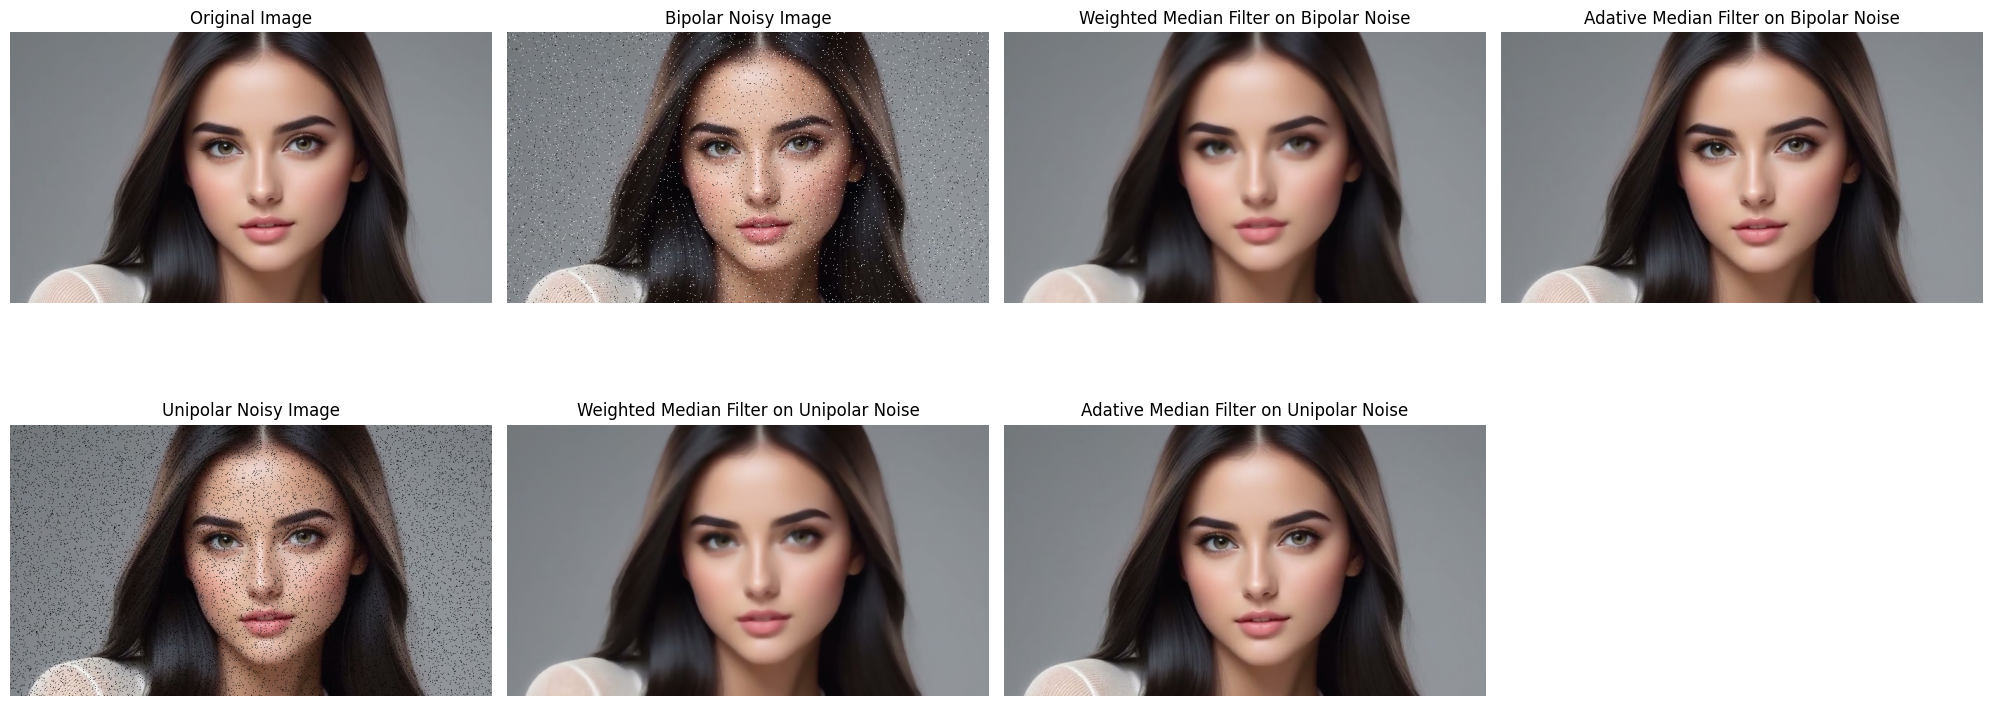

In [ ]:
import numpy as np
import cv2
from scipy.ndimage import median_filter
from google.colab import files
import matplotlib.pyplot as plt

# Function to add Bipolar Impulse Noise
def add_bipolar_impulse_noise(image, prob):
    noisy_image = image.copy()
    total_pixels = image.size // image.shape[2]  # Total number of pixels
    num_noisy_pixels = int(prob * total_pixels)  # Number of noisy pixels

    # Randomly choose pixels to corrupt
    x_coords = np.random.randint(0, image.shape[0], num_noisy_pixels)
    y_coords = np.random.randint(0, image.shape[1], num_noisy_pixels)

    for x, y in zip(x_coords, y_coords):
        if np.random.rand() < 0.5:
            noisy_image[x, y] = 0  # Set to black
        else:
            noisy_image[x, y] = 255  # Set to white

    return noisy_image

# Function to add Unipolar Impulse Noise
def add_unipolar_impulse_noise(image, prob, polarity=0):
    """
    Add Unipolar Impulse Noise to the image.
    :param image: Input image.
    :param prob: Probability of noise.
    :param polarity: 0 for black noise, 255 for white noise.
    """
    noisy_image = image.copy()
    total_pixels = image.size // image.shape[2]  # Total number of pixels
    num_noisy_pixels = int(prob * total_pixels)  # Number of noisy pixels

    # Randomly choose pixels to corrupt
    x_coords = np.random.randint(0, image.shape[0], num_noisy_pixels)
    y_coords = np.random.randint(0, image.shape[1], num_noisy_pixels)

    for x, y in zip(x_coords, y_coords):
        noisy_image[x, y] = polarity

    return noisy_image

# Function to apply a Weighted Median (WM) filter
def weighted_median_filter(image, kernel_size):
    def weighted_median(data, weights):
        """Compute the weighted median from data and weights."""
        sorted_indices = np.argsort(data)
        data = data[sorted_indices]
        weights = weights[sorted_indices]
        cumulative_weights = np.cumsum(weights)
        midpoint = cumulative_weights[-1] / 2
        return data[np.searchsorted(cumulative_weights, midpoint)]

    padded_image = np.pad(image, ((kernel_size // 2, kernel_size // 2), (kernel_size // 2, kernel_size // 2), (0, 0)), mode='reflect')
    filtered_image = np.zeros_like(image)

    kernel = np.ones((kernel_size, kernel_size))

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for c in range(image.shape[2]):
                region = padded_image[i:i + kernel_size, j:j + kernel_size, c]
                weighted_median_value = weighted_median(region.flatten(), kernel.flatten())
                filtered_image[i, j, c] = weighted_median_value

    return filtered_image

# Function to apply an Adaptive Median Filter
def adaptive_median_filter(image, max_kernel_size):
    def adaptive_median_pixel(region, kernel_size, max_kernel_size):
        z_min = np.min(region)
        z_max = np.max(region)
        z_med = np.median(region)
        z_xy = region[kernel_size // 2, kernel_size // 2]

        if z_med > z_min and z_med < z_max:
            if z_xy > z_min and z_xy < z_max:
                return z_xy
            else:
                return z_med
        else:
            # Increase kernel size if necessary
            if kernel_size < max_kernel_size:
                return None
            else:
                return z_med

    padded_image = np.pad(image, ((max_kernel_size // 2, max_kernel_size // 2), (max_kernel_size // 2, max_kernel_size // 2), (0, 0)), mode='reflect')
    filtered_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for c in range(image.shape[2]):
                kernel_size = 3
                while kernel_size <= max_kernel_size:
                    region = padded_image[i:i + kernel_size, j:j + kernel_size, c]
                    result = adaptive_median_pixel(region, kernel_size, max_kernel_size)
                    if result is not None:
                        filtered_image[i, j, c] = result
                        break
                    kernel_size += 2  # Increment kernel size by 2

    return filtered_image

# File upload dialog for Colab
def upload_image():
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    return file_name

# Main execution
image_path = upload_image()
if image_path:
    image = cv2.imread(image_path)

    # Add Bipolar Impulse Noise
    impulse_prob = 0.03  # Probability of impulse noise
    bipolar_noisy_image = add_bipolar_impulse_noise(image, impulse_prob)

    # Add Unipolar Impulse Noise
    unipolar_prob = 0.05  # Probability of unipolar impulse noise
    unipolar_noisy_image = add_unipolar_impulse_noise(image, unipolar_prob, polarity=0)  # Black noise

    # Apply filters for Bipolar Noise
    kernel_size = 7  # Kernel size for the weighted median filter
    max_kernel_size = 7  # Maximum kernel size for the adaptive median filter

    wm_filtered_bipolar = weighted_median_filter(bipolar_noisy_image, kernel_size)
    am_filtered_bipolar = adaptive_median_filter(bipolar_noisy_image, max_kernel_size)

    # Apply filters for Unipolar Noise
    wm_filtered_unipolar = weighted_median_filter(unipolar_noisy_image, kernel_size)
    am_filtered_unipolar = adaptive_median_filter(unipolar_noisy_image, max_kernel_size)

    # Display the results
    plt.figure(figsize=(25, 8))

    plt.subplot(2, 5, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(2, 5, 2)
    plt.title("Bipolar Noisy Image")
    plt.imshow(cv2.cvtColor(bipolar_noisy_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(2, 5, 3)
    plt.title("Weighted Median Filter on Bipolar Noise")
    plt.imshow(cv2.cvtColor(wm_filtered_bipolar, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(2, 5, 4)
    plt.title("Adaptive Median Filter on Bipolar Noise")
    plt.imshow(cv2.cvtColor(am_filtered_bipolar, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(2, 5, 6)
    plt.title("Unipolar Noisy Image")
    plt.imshow(cv2.cvtColor(unipolar_noisy_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(2, 5, 7)
    plt.title("Weighted Median Filter on Unipolar Noise")
    plt.imshow(cv2.cvtColor(wm_filtered_unipolar, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(2, 5, 8)
    plt.title("Adaptive Median Filter on Unipolar Noise")
    plt.imshow(cv2.cvtColor(am_filtered_unipolar, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()

    plt.show()

    # Save the results
    cv2.imwrite("bipolar_noisy_image.jpg", bipolar_noisy_image)
    cv2.imwrite("unipolar_noisy_image.jpg", unipolar_noisy_image)
    cv2.imwrite("wm_filtered_bipolar.jpg", wm_filtered_bipolar)
    cv2.imwrite("am_filtered_bipolar.jpg", am_filtered_bipolar)
    cv2.imwrite("wm_filtered_unipolar.jpg", wm_filtered_unipolar)
    cv2.imwrite("am_filtered_unipolar.jpg", am_filtered_unipolar)
